In [3]:
!nvidia-smi

Wed Aug 31 04:14:19 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Setup environment

In [ ]:
# mount driver
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/CardiacSeg/UNETCNX/CHGH

# install dependents
!pip install monailabel-weekly
!pip install monai
!pip uninstall opencv-contrib-python -y
!pip install opencv-python==4.1.2.30 opencv-contrib-python==4.1.2.30

# sync python module
%load_ext autoreload
%autoreload 2

## Import library

In [182]:
import sys
# set package path
sys.path.append("/content/drive/MyDrive/CardiacSeg")

import argparse
import os
from functools import partial

import torch
import pandas as pd
import matplotlib.pyplot as plt

from monai.transforms import (
    AsDiscrete,
    AddChanneld,
    LoadImaged,
    Compose,
    Orientationd,
    ToNumpyd
)
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.utils import first
from monailabel.transform.post import BoundingBoxd, Restored

from data_utils.chgh_dataset import get_data_dicts, get_infer_data
from data_utils.utils import get_pids_by_data_dicts
from data_utils.visualization import show_img_lbl_pred, show_img_lbl
from data_utils.io import save_img
from runners.inferer import run_infering
from networks.unetcnx import UNETCNX

## Setup config

In [177]:
parser = argparse.ArgumentParser(description="model segmentation pipeline")

# dir and path
parser.add_argument("--data_dir", default="", type=str, help="dataset directory")
parser.add_argument("--model_dir", default="models", type=str, help="directory to save the models")
parser.add_argument("--log_dir", default="logs", type=str, help="directory to save the tensorboard logs")
parser.add_argument("--eval_dir", default="evals", type=str, help="directory to save the eval result")
parser.add_argument("--infer_dir", default="infers", help="directory to save the infers result")
parser.add_argument("--checkpoint", default=None, help="start training from saved checkpoint")
parser.add_argument("--filename", default="best_model.pth", help="save model file name")

# model
parser.add_argument("--in_channels", default=1, type=int, help="number of input channels")
parser.add_argument("--out_channels", default=2, type=int, help="number of output channels")

# infer
parser.add_argument("--sw_batch_size", default=4, type=int, help="number of sliding window batch size")
parser.add_argument("--infer_overlap", default=0.25, type=float, help="sliding window inference overlap")

# args
args, unknown = parser.parse_known_args()

# setup config
model_name = 'base_cv1'
root_dir = '/content/drive/MyDrive/CardiacSeg/UNETCNX/CHGH'

args.data_dir = '/content/drive/MyDrive/CardiacSeg/dataset/CHGH/dataset'
args.model_dir = os.path.join(root_dir, 'models', model_name)
args.log_dir = os.path.join(root_dir, 'logs', model_name)
args.eval_dir = os.path.join(root_dir, 'evals', model_name)
args.infer_dir = os.path.join(root_dir, 'infers', model_name)
args.checkpoint = os.path.join(args.model_dir, 'best_model.pth')

args.with_label = True

# device
if torch.cuda.is_available():
    print("cuda is available")
    args.device = torch.device("cuda")
else:
    print("cuda is not available")
    args.device = torch.device("cpu")

cuda is available


## Make dir

In [178]:
# make dir
os.makedirs(args.infer_dir, exist_ok=True)

## Read data

In [ ]:
get_pids_by_data_dicts()

In [184]:
idx = -1
data_dict = get_data_dicts(args.data_dir)[-1]
pid = get_pids_by_data_dicts([data_dict])[0]
print('pid:', pid)
print('data_dict:', data_dict)

pid: Patient_108
data_dict: {'image': '/content/drive/MyDrive/CardiacSeg/dataset/CHGH/dataset/Patient_108/Patient_108.nii.gz', 'label': '/content/drive/MyDrive/CardiacSeg/dataset/CHGH/dataset/Patient_108/GT.nii.gz'}


In [169]:
if args.with_label:
  keys = ['image', 'label']
  data = get_infer_data(data_dict, keys, args)
else:
  keys = ['image']
  data = get_infer_data(data_dict, keys, args)

## Check data

img path: /content/drive/MyDrive/CardiacSeg/dataset/CHGH/dataset/Patient_108/Patient_108.nii.gz
original img shape: (512, 512, 267)
transformed img shape: (1, 1, 173, 173, 174)


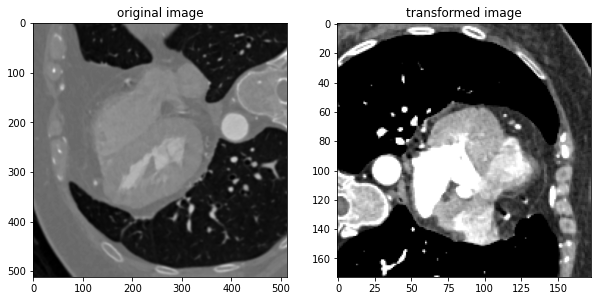

In [74]:
# check data
src_img = LoadImaged(keys=['image'])(data_dict)['image']
tf_img = data['image']
slice_idx = tf_img.shape[-1] // 2

print(f"img path: {data_dict['image']}")
print(f"original img shape: {src_img.shape}")
print(f"transformed img shape: {tf_img.shape}")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))
axes[0].title.set_text("original image")
axes[0].imshow(src_img[:,:,slice_idx], cmap='gray')
axes[1].title.set_text("transformed image")
axes[1].imshow(tf_img[0,0,:,:,slice_idx], cmap='gray')

## Setup model

In [16]:
# model
model = UNETCNX(
    in_channels=args.in_channels,
    out_channels=args.out_channels,
    feature_size=48,
    patch_size=4
).to(args.device)

## Load checkpoint

In [20]:
# check point
best_acc = 0
if args.checkpoint is not None:
    checkpoint = torch.load(args.checkpoint, map_location="cpu")
    from collections import OrderedDict

    new_state_dict = OrderedDict()
    for k, v in checkpoint["state_dict"].items():
        new_state_dict[k.replace("backbone.", "")] = v
    model.load_state_dict(new_state_dict, strict=False)
    if "epoch" in checkpoint:
        start_epoch = checkpoint["epoch"]
    if "best_acc" in checkpoint:
        best_acc = checkpoint["best_acc"]
    print("=> loaded checkpoint '{}' (epoch {}) (bestacc {})".format(args.checkpoint, start_epoch, best_acc))

=> loaded checkpoint '/content/drive/MyDrive/CardiacSeg/UNETCNX/CHGH/models/base_cv1/best_model.pth' (epoch 2240) (bestacc 0.8624954223632812)


# Setup inferer

In [172]:
# inferer
post_label = AsDiscrete(to_onehot=args.out_channels)
post_pred = Compose([
    Orientationd(keys=["pred"], axcodes="LPS"),
    ToNumpyd(keys=["pred"]),
    Restored(keys=["pred"], ref_image="image"),
    BoundingBoxd(keys=["pred"], result="result", bbox="bbox")
])
model_inferer = partial(
    sliding_window_inference,
    roi_size=[96, 96, 96],
    sw_batch_size=args.sw_batch_size,
    predictor=model,
    overlap=args.infer_overlap,
)

## Infer

In [175]:
data['pred'] = run_infering(
    model,
    data,
    model_inferer,
    args.device
)
data = post_pred(data)

`data_array` is not of type `MetaTensor, assuming affine to be identity.


## Show result

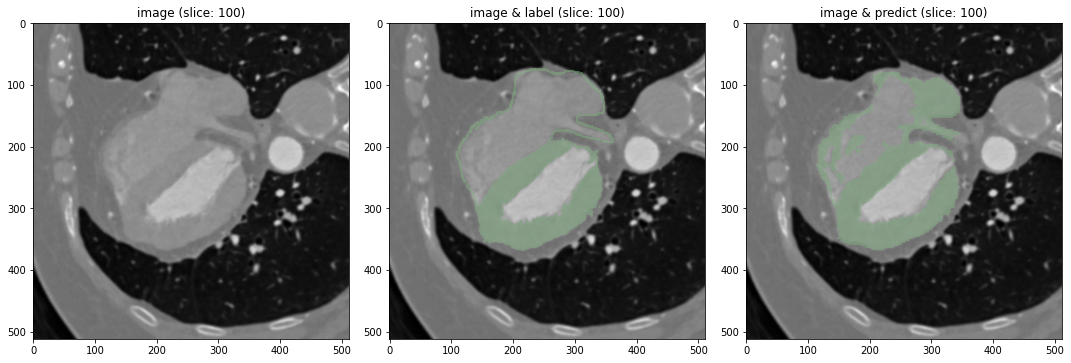

In [176]:
num_classes = 2
slice_idx = 100
alpha = 0.5
axis_off = False
fig_size = (15, 5)

if args.with_label:
    src_data = LoadImaged(keys=['image', 'label'])(data_dict)
    show_img_lbl_pred(
        src_data['image'][:,:,slice_idx],
        src_data['label'][:,:,slice_idx],
        data['pred'][:,:,slice_idx],
        slice_idx,
        num_classes, 
        axis_off,
        alpha,
        fig_size
    )
else:
    src_data = LoadImaged(keys=['image'])(data_dict)
    show_img_lbl(
        src_data['image'][:,:,slice_idx],
        src_data['pred'][:,:,slice_idx],
        slice_idx,
        num_classes, 
        axis_off,
        alpha,
        fig_size
    )

## Save result

In [185]:
save_img(
    data['pred'], 
    data['pred_meta_dict'],
    os.path.join(args.infer_dir, f'infer_{pid}.nii.gz')
)

2022-08-31 07:16:51,382 INFO image_writer.py:192 - writing: /content/drive/MyDrive/CardiacSeg/UNETCNX/CHGH/infers/base_cv1/infer_Patient_108.nii.gz
